In [ ]:
import numpy as np
import cv2 
from pathlib import Path
import sys
import os
import matplotlib.pyplot as plt





###############---------------UTILIIES---------------------#########################

# common functuions to be used for all question 1-3 for traslation rotation and scaling

#   THIS FUNCTION CREATES A GRID FOR OUR SOURCE COORDINATES ACCORDING
#    TO IMAGE HIEGHT AND WIDTH IN AFFINE FORM SO ITS LIKE [X,Y,1](HOMOGENOUS COORDINATES ) STACKED TO FORM 3D GRID
# WHERE EACH X AND Y DENOTE SRC COORDIANTE INDEX


def create_grid(h, w):                                  
    y, x = np.indices((h, w))                           
    ones = np.ones_like(x)
    coords = np.stack([x, y, ones], axis=0)  # (3, H, W)
    return coords.reshape(3, -1)             # (3, H*W)


def bilinear_interpolate(img, x, y):
    H, W ,c= img.shape

    x0 = np.floor(x).astype(int)
    x1 = x0 + 1
    y0 = np.floor(y).astype(int)
    y1 = y0 + 1

    x0 = np.clip(x0, 0, W-1)
    x1 = np.clip(x1, 0, W-1)
    y0 = np.clip(y0, 0, H-1)
    y1 = np.clip(y1, 0, H-1)

    Ia = img[y0, x0]
    Ib = img[y1, x0]
    Ic = img[y0, x1]
    Id = img[y1, x1]

    wa = (x1-x)*(y1-y)
    wb = (x1-x)*(y-y0)
    wc = (x-x0)*(y1-y)
    wd = (x-x0)*(y-y0)

    return (Ia.T*wa + Ib.T*wb + Ic.T*wc + Id.T*wd).T


###############--------------------------------############################


In [28]:
script_dir = Path(os.getcwd()).resolve()


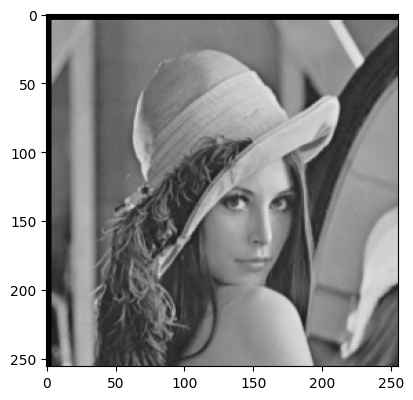

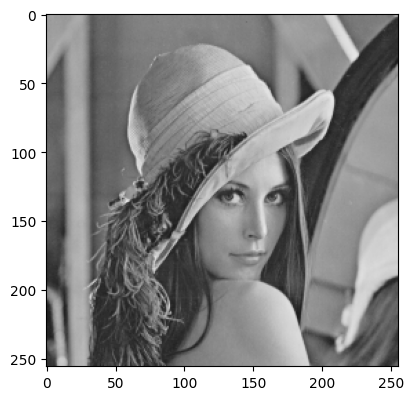

In [ ]:
# question 1
img_path=script_dir/"lena_translate.png"
lena=cv2.imread(img_path)

# desired translation

tx,ty= 3.75 , 4.3 


# matrix for desired translation
T=np.array([[1,0,tx],
            [0,1,ty],
            [0,0,1]])


h,w,c=lena.shape

# creating a homogenous grid with shape (h*w,3) denoting all coordiantes homogenous in assumed translated image
#1st row :x
# 2nd row :y
# 3rd row :1s
grid=create_grid(h,w)

# applying int T to obtain coordiantes in src image
scr_coor= np.linalg.inv(T) @ grid

# x and y in src coordinates(transformed from grid)
x_src=scr_coor[0, :]
y_src=scr_coor[1, :]

valid= (x_src >= 0) & (x_src < w-1) & (y_src >= 0) & (y_src < h-1)

output = np.zeros((h*w , c))  #array for storing interpolated coordinates
output[valid] = bilinear_interpolate(
        lena,
        x_src[valid],
        y_src[valid]
    )


#reshaping the array to original image size from homogenous shape
lena_translated=output.reshape(h,w,c).astype(lena.dtype)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(lena)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 2)
plt.imshow(lena_translated)


plt.show()





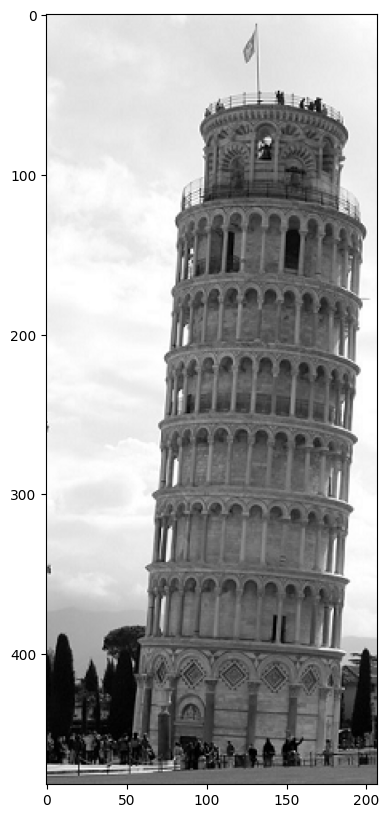

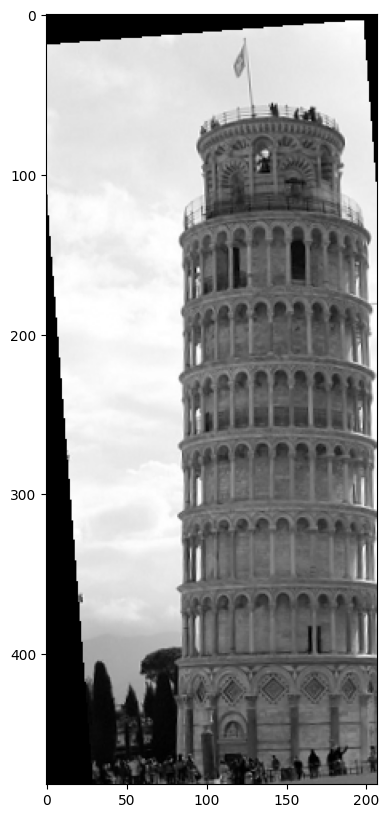

In [29]:
#ques 2
img_path=script_dir/"pisa_rotate.png"


pisa=cv2.imread(img_path)

h,w,c=pisa.shape
# print(pisa.shape)
cx,cy= w/2 ,h/2


#bringing homogenous coordiantes to centre so that t=roation is about centre and not top left
T1=np.array([[1,0,cy],
            [0,1,cx],
            [0,0,1]])


theta=np.deg2rad(-4.5)

# applying rotation

R = np.array([
        [np.cos(theta), -np.sin(theta), 0],
        [np.sin(theta),  np.cos(theta), 0],
        [0, 0, 1]
    ])


#translating the  homogenous coordiantes back to original config.
T2=np.array([[1,0,-cy],
            [0,1,-cx],
            [0,0,1]])

#net total tranformations
T_rot=  T1 @ R @ T2


 # creating a homogenous grid with shape (h*w,3) denoting all coordiantes homogenous in assumed translated image
    #1st row :x
    # 2nd row :y
    # 3rd row :1s
coords = create_grid(h,w)

   # applying int T to obtain coordiantes in src image
src_coords = np.linalg.inv(T_rot) @ coords


   # x and y in src coordinates(transformed from grid)
x_src = src_coords[0, :]
y_src = src_coords[1, :]

valid= (x_src >= 0) & (x_src < w-1) & (y_src >= 0) & (y_src < h-1)


#array for storing interpolated coordinates
output = np.zeros((h*w,c))
output[valid] = bilinear_interpolate(
    pisa,
    x_src[valid],
    y_src[valid]
)



#reshaping the array to original image size from homogenous shape
pisa_rotated=output.reshape(h,w,c).astype(pisa.dtype)   

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(pisa)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 2)
plt.imshow(pisa_rotated)


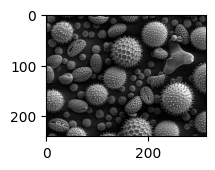

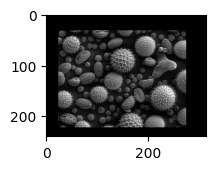

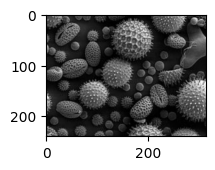

In [33]:

img_path=script_dir/"cells_scale.png"

cells=cv2.imread(img_path)
h,w,c=cells.shape
cx,cy=w/2,h/2

#bringing homogenous coordiantes to centre so that scaling is about centre and not top left

T1=np.array([[1,0,cy],
            [0,1,cx],
            [0,0,1]])


# sacling by 0.8

S1=np.array([[0.8,0,0],
             [0,0.8,0],
             [0,0,1]])


#scaling by 1.3

S2=np.array([[1.3,0,0],
            [0,1.3,0],
            [0,0,1]])

T2=np.array([[1,0,-cy],
            [0,1,-cx],
            [0,0,1]])


coords = create_grid(h,w)


src_coords = np.linalg.inv(T1 @ S2 @ T2) @ coords  #scaling by 1.3

src_coords_2=np.linalg.inv(T1 @ S1 @ T2) @ coords   #sclain by 0.8


x_src = src_coords[0, :]
y_src = src_coords[1, :]


x_src_2=src_coords_2[0,:]
y_src_2=src_coords_2[1,:]




valid= (x_src >= 0) & (x_src < w-1) & (y_src >= 0) & (y_src < h-1)


output = np.zeros((h*w,c))
output_2=np.zeros((h*w,c))


output[valid] = bilinear_interpolate(cells, x_src[valid],  y_src[valid])

output_2[valid]=bilinear_interpolate(cells, x_src_2[valid], y_src_2[valid])

cells_scaled_up=output.reshape(h,w,c).astype(cells.dtype)
cells_scaled_down=output_2.reshape(h,w,c).astype(cells.dtype)

plt.figure(figsize=(7,7))
plt.subplot(1, 3, 1)
plt.imshow(cells)

plt.figure(figsize=(7,7))
plt.subplot(1, 3, 2)
plt.imshow(cells_scaled_down)


plt.figure(figsize=(7,7))
plt.subplot(1, 3, 3)
plt.imshow(cells_scaled_up)

